In [1]:
import pandas as pd
import numpy as np
import pickle
from FPMC import FPMC as FM
import dill
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

%matplotlib inline

In [3]:
fName = 'fullModel-9June.pcl'
userNumber = 206290 #- full set
itemsNumber = 49688
obj = FM(users=userNumber+1, items=itemsNumber+1, k=16)
obj.load(fName)

In [4]:
# import products description
products    =  pd.read_csv('../data/products.csv',index_col='product_id')

In [5]:
orders = pd.read_csv('../data/orders.csv',index_col = 'order_id',
                     usecols = ['order_id','user_id','eval_set','order_number','days_since_prior_order'])

usecols = ['order_id','product_id']
items = pd.concat([pd.read_csv('../data/order_products__train.csv',usecols = usecols),
                   pd.read_csv('../data/order_products__prior.csv',usecols = usecols)])

/home/frodos/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
def f1Score(y_true, y_pred):
    fullSet      = np.unique(np.hstack((y_pred,y_true)))
    intersection = np.intersect1d(y_true,y_pred).size
    precession   = intersection/float(y_pred.shape[0])
    recall       = intersection/float(y_true.shape[0])
    try:
        f1 = 2*precession*recall/(precession+recall)
    except ZeroDivisionError:
        f1 = 0
    return [precession, recall, f1]

In [7]:
def testModel(tUser,verbose = False, addPrev = False):
    userOrders = orders.query('user_id == @tUser')

    testOrder = userOrders.query("eval_set != 'prior'")

    trainOrders = userOrders.query("eval_set == 'prior'")
    trainOrderIds = trainOrders.index.values

    if testOrder.eval_set.values == 'test':
        print 'Test user'
        return

    else:
        testOrderId = testOrder.index.values

    # получаем id всех предварительных заказов    

    # train the model
    if addPrev:
        prevOrderId = userOrders.query('order_number == 1').index.values
        prevBasket = items.query('order_id == @prevOrderId').product_id.values

        for newOrderId in userOrders.index.values[1:-1]:
            if verbose:
                print 'Order id is', newOrderId
            newBasket = items.query('order_id == @newOrderId').product_id.values
            obj.addOrder(tUser,newBasket,prevBasket,iterations = 1e3)
            prevBasket = newBasket
    else:
        prevOrderNumber =  testOrder.order_number.values - 1
        prevOrderId = userOrders.query('order_number == @prevOrderNumber').index.values
        prevBasket = items.query('order_id == @prevOrderId').product_id.values

    testBasket = items.query('order_id == @testOrderId').product_id.values

    ordIds = userOrders.index.values[:-1]
    
    userItems = items.query('order_id in @trainOrderIds')

    # формирование полного списка купленного 
    fullBasket = userItems.groupby('product_id').count() 
    fullBasket.rename(columns={'order_id':'quantity'},inplace=True)
    fullBasket = fullBasket.merge(products,left_index=True,right_index=True).drop(['aisle_id','department_id'],axis = 1) 
    
    # расчёт среднего размера корзины
    size = np.round(userItems.groupby('order_id').count().mean()).values
    
    for k ,v in fullBasket.iterrows():
        fullBasket.loc[k,'prob'] =  obj.getProbability(basket=prevBasket, item=k, user=tUser)
        fullBasket.loc[k,'wasOrdered'] = k in testBasket
    
    
    fullBasket.sort_values('wasOrdered',ascending=False,inplace=True)
    ##fullBasket.head(50)
    fpr, tpr, thresholds = roc_curve(fullBasket.wasOrdered,fullBasket.prob)
    plt.plot(fpr,tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    print 'FPMC model'
    recommendation = fullBasket.sort_values('prob',ascending=False).index.values[:int(size)]
    print recommendation
    [pr, recall, f1] = f1Score(testBasket,recommendation)
    print 'Precession ', pr
    print 'Recall ', recall
    print 'f1-score ',f1
    
    print '\nMost popular model'
    recommendation = fullBasket.sort_values('quantity',ascending=False).index.values[:int(size)]
    print recommendation
    [pr, recall, f1] = f1Score(testBasket,recommendation)
    print 'Precession ', pr
    print 'Recall ', recall
    print 'f1-score ',f1
    
    return [fullBasket, pr, recall, f1]

FPMC model
[26088 10326 13032 25133 35951 14084]
Precession  0.5
Recall  0.272727272727
f1-score  0.352941176471

Most popular model
[  196 12427 10258 25133 13032 46149]
Precession  0.833333333333
Recall  0.454545454545
f1-score  0.588235294118


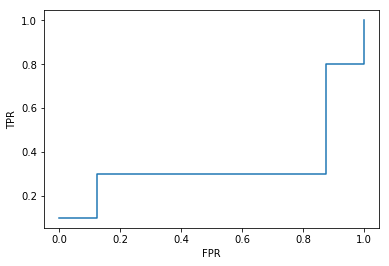

In [35]:
obj.load(fName)
[b,p,r,f1] = testModel(1)

FPMC model
[33276 13742 15841 33957 21150 19156 49451  7781 35917 30908 41787 22829
  8479 44303]
Precession  0.142857142857
Recall  0.0645161290323
f1-score  0.0888888888889

Most popular model
[32792 47209 24852  1559 18523 19156 12000 16589 33754 22124 47766  2002
 19051 32139]
Precession  0.214285714286
Recall  0.0967741935484
f1-score  0.133333333333


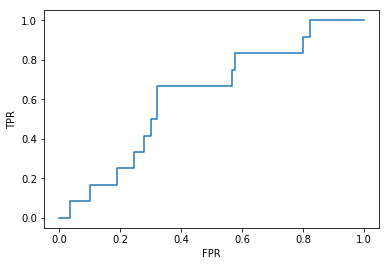

In [36]:
obj.load(fName)
[b,p,r,f1] = testModel(2)

FPMC model
[21650 17993  9116 37004]
Precession  0.5
Recall  0.333333333333
f1-score  0.4

Most popular model
[17993 21650 23734  9116]
Precession  0.75
Recall  0.5
f1-score  0.6


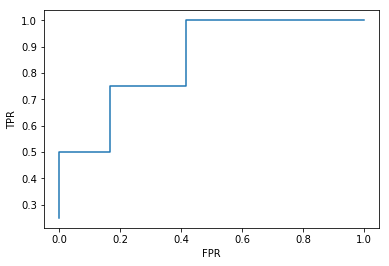

In [37]:
obj.load(fName)
[b,p,r,f1] = testModel(200222,verbose=True)

FPMC model
[41875 11869  5210  9068 15268 31878 18284 44048 13029 32448]
Precession  0.2
Recall  0.142857142857
f1-score  0.166666666667

Most popular model
[31981 24852 42633 29363 44799 13029  6224 15268 32448  6131]
Precession  0.5
Recall  0.357142857143
f1-score  0.416666666667


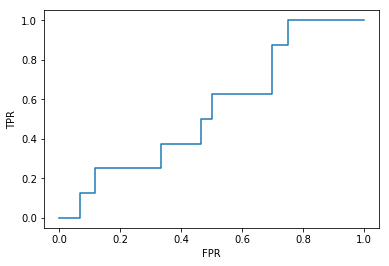

In [40]:
obj.load(fName)
[b,p,r,f1] = testModel(226, verbose=True)

In [39]:
b

,quantity,product_name,prob,wasOrdered
product_id,,,,
13029,8,Ready Pac Salad Santa Fe Caesar Bowls,6.293002,True
29363,15,Cinnamon Cereal,1.799965,True
4137,1,Whole Grain Oat Cereal,-6.354629,True
39646,5,"Red Onions, Fresh Diced",-4.731535,True
24852,20,Banana,0.669205,True
9076,1,Blueberries,-2.176591,True
31981,21,1% Low Fat Milk,-4.545704,True
15268,6,Tai Pei Orange Chicken,13.708004,True
4094,1,Lean Gourmet Five Cheese Lasagna,4.659314,False
